In [ ]:
#hide
from fastai.basics import *
from fastai.callback.all import ShortEpochCallback
from pt_memprofile.core import *
from reformer_fastai.all import *

In [ ]:
#hide
#all_slow

# pt_memprofile

> Utilities for cuda memory usage inspection for pytorch and fastai.

## Installation

`pip install -qq git+git://github.com/arampacha/pt_memprofile.git`

## How to use

### Profiling TransformerLM

In [ ]:
bs, sl = 8, 128
dls = DataLoaders.from_dsets(DeterministicTwinSequence(sl, 10*bs), 
                             DeterministicTwinSequence(sl, 2*bs), 
                             bs=bs, shuffle=False, device='cuda')
model = TransformerLM(128, 256)

In [ ]:
xb, yb = dls.one_batch()
memlog1 = memprofile(model, xb, yb, plot=False, label='fp32')
memlog2 = memprofile(model, xb, yb, plot=False, label='fp16', fp16=True)

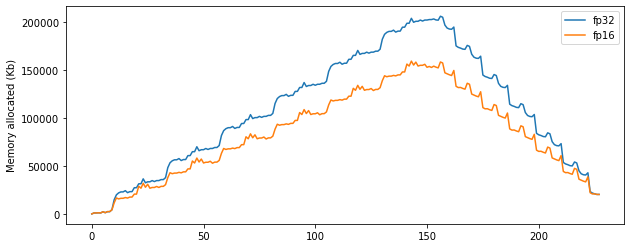

In [ ]:
plot_logs(memlog1, memlog2)

### Fastai interface

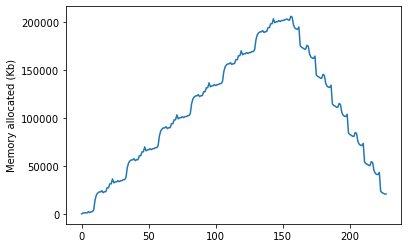

In [ ]:
learn = Learner(dls, model, loss_func=CrossEntropyLossFlat())
memlog1 = learn.profile_memory()

### Profiling epoch

> Note: Memory profiling slows down training significantly, so you probably don't want to run it for a comlete epoch.

Let's examine effect of optimizer to memory usage:

In [ ]:
#hide_output
#cuda
learn = Learner(simple_dls(), simple_model(), loss_func=CrossEntropyLossFlat(), cbs=MemStatsCallback(label='SGD'), opt_func=SGD)
with learn.no_bar(): learn.fit(1, 1e-3, cbs=[ShortEpochCallback(pct=0.1)])
memlog1 = learn.mem_stats.stats
learn = Learner(simple_dls(), simple_model(), loss_func=CrossEntropyLossFlat(), cbs=MemStatsCallback(label='Adam'), opt_func=Adam)
with learn.no_bar(): learn.fit(1, 1e-3, cbs=[ShortEpochCallback(pct=0.1)])
memlog2 = learn.mem_stats.stats
learn = Learner(simple_dls(), simple_model(), loss_func=CrossEntropyLossFlat(), cbs=MemStatsCallback(label='Adafactor'), opt_func=adafactor)
with learn.no_bar(): learn.fit(1, 1e-3, cbs=[ShortEpochCallback(pct=0.1)])
memlog3 = learn.mem_stats.stats

[0, '00:00']
[0, '00:00']
[0, '00:00']


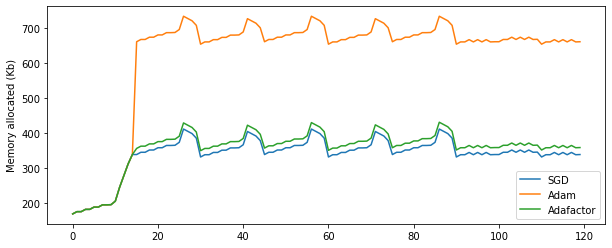

In [ ]:
plot_logs(memlog1, memlog2, memlog3)